In [2]:
import pandas as pd
import numpy as np
import scipy.io as sc
from scipy.io import wavfile
import tkinter as tk
from tkinter import *
from tkinter import ttk as ttk
from tkinter import filedialog as fd
from tkinter.messagebox import showinfo
import os as os
from pydub import AudioSegment
from pydub.playback import play
import subprocess
import math
import random
import datetime
#from datetime import datetime
from datetime import timedelta
from pytz import timezone
from PIL import ImageTk , Image

# Dependency - QuickTimePlayer on mac
# REMINDERS - change all paths and specific variables ; change try catch pattern of default players for different OS

# GLOBAL VARIABLES
ctc_timestamps_main = None
chn_timestamps_main = None
childid = None
sorted_ctccount = None
list_of_randoms = []
list_of_randoms_2 = []
rate = None # stores wavfile audio info
wavdata = None # stores wavfile audio info
checkbutton_value  = None
long_CTCs_offsets = []
all_avail_IDs = []
LENA_start_time = None

#GLOBAL CONSTANTS TO CHANGE:
path_to_working_folder = '/Users/arjun/Box/box-group-lena-studies/Soundscape/ucsf_app_stuff'

In [26]:
#!pip install playsound
# !pip3 uninstall PyObjC -y
# !pip install pydub

Found existing installation: pyobjc 10.0
Uninstalling pyobjc-10.0:
  Successfully uninstalled pyobjc-10.0


In [2]:
'''
def quitme():
    master.withdraw()
    master.destroy()
    
def show_entry_fields():
    entries = tk.Toplevel(master)
    entries.title("Secondary Window")
    l1 = tk.Label(entries, text="First Name =  "+e1.get())
    l1.grid(row=0)
    l2 = tk.Label(entries,text="Last Name = "+e2.get())
    l2.grid(row=1)
    l3 = tk.Label(entries,text="Number you chose: =  " + combo.get())
    l3.grid(row=2, column=0) 
    button_close = ttk.Button(entries, text = "Close", command = lambda: [entries.withdraw(), entries.destroy()])
    button_close.grid(row=2,column=1)

valuegot="0"    
master = tk.Tk()
l11 = tk.Label(master, text="First Name")
l11.grid(row=0)

l12 = tk.Label(master, text="Last Name")
l12.grid(row=1)

e1 = tk.Entry(master)
e1.grid(row=0, column=1)

e2 = tk.Entry(master)
e2.grid(row=1, column=1)


b1 = tk.Button(master, text='Quit', command= quitme)
b1.grid(row=3, column=2, sticky=tk.W, pady=4)


global valuegot 

combo = ttk.Combobox(master,state="readonly", values=["1", "2", "3", "4"])
combo.grid(row=4, column=1)
valuegot = combo.get()
print(valuegot)

b2 = tk.Button(master, text='Show', command=show_entry_fields)
b2.grid(row=3, column=1, sticky=tk.W,pady=4)

tk.mainloop()
'''

In [2]:
# some processing work before running actual tk loop
path_of_childids = os.path.join(path_to_working_folder, 'avail_child_ID.txt')
global all_avail_IDs
with open(path_of_childids) as file:
  for item in file:
    all_avail_IDs.append(item.strip())

In [3]:
# helper functions

def getrealtime(i):

    infocsvpath = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles" , childid + "_speech_output",  childid+"_its_info.csv")
    
    itsinfocsv = pd.read_csv(infocsvpath)
    datetime_str = str(itsinfocsv['startClockTime'][0])
    datetime_object = datetime.datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
    datetime_object = datetime_object.replace(tzinfo=datetime.timezone.utc)

    LENA_start_time = datetime_object
    offset_amount = int(long_CTCs_offsets[i][0])
    actual_time_of_clip_UTC = LENA_start_time + timedelta(seconds = offset_amount)
    
    if (childid.find('L')>=0 or childid.find('M')>=0  or childid.find('D')>=0  or childid.find('E')>=0):
        actual_time_of_clip = actual_time_of_clip_UTC.astimezone(timezone('America/Chicago'))

    if (childid.find('R')>=0 or childid.find('J')>=0):
        actual_time_of_clip = actual_time_of_clip_UTC.astimezone(timezone('America/New_York'))
    
    return actual_time_of_clip

In [4]:
which_child = None


def select_file():
    wantfiletypes = [ ('CSV files', '*.csv') ]
    filepath = fd.askopenfilename( title='Open a file', initialdir='/', filetypes = wantfiletypes)
    nameofcsv = os.path.basename(filepath)
    underscore = nameofcsv.find('_')
    global childid 
    childid = nameofcsv[:underscore]
    message = "You are now viewing child ID: " + childid + "!"
    showinfo(title='Selected File', message = message)
    global rate 
    global wavdata
    directory = "/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles"
    wavpath = os.path.join(directory, childid+".wav")
    rate, wavdata = wavfile.read(wavpath)
    global ctc_timestamps_main 
    ctc_timestamps_main= pd.read_csv(filepath)
    showinfo(title='Status Update', message = "You can now use the interface.")
    if ctc_timestamps_main['segment_type'][0]!='CTC':
        print("You have chosen the wrong file. Please close the window and try again.")
    
    
def prepare_CTCclips():
    '''
    This function prepares a dataframe with clips arrranged in descending order of CTC count
    '''
    global sorted_ctccount
    sorted_ctccount = ctc_timestamps_main.sort_values(by=['convo_count'], ascending=0, ignore_index = 1) 
    
    
    
def extract_clips_longCTC ():
    '''
    This function extracts and saves the clip with the longest CT measured by convo count, not duration.
    It also extracts the top 15 clips based on CTC count length.
    '''
    directory = "/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles"
    path = os.path.join(directory, childid+".wav")
    
    prepare_CTCclips()
    upperbound = 15

    global long_CTCs_offsets

    if (15>=len(sorted_ctccount)):
        upperbound = len(sorted_ctccount)
        
    for i in range(0 , upperbound):
        start, ending = sorted_ctccount.at[i,'clip_onset'] , sorted_ctccount.at[i,'clip_offset']
        split_at_frame = math.floor(rate * start)
        stop_at_frame = math.ceil(rate * ending)
        left_data  = wavdata[split_at_frame : stop_at_frame] 
        long_CTCs_offsets.append((start,ending))
        # TODO : change this file path for outputs
        newpath = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles/sample_expt_arjun" , childid+ "_longCTC"+str(i)+".wav")
        wavfile.write(newpath, rate, left_data)

    showinfo(title='Status Update', message = "File extraction process complete.")
 
    # idea : dropdown for all available options to play audio -- do this if lot of things to do
    

def play_longest_CTC():
    '''
    This function plays the clip with the longest CT measured by convo count which has been extracted
    '''    

    global LENA_start_time
    filetoplay = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles/sample_expt_arjun" , childid+ "_longCTC0.wav")
    
    '''infocsvpath = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles" , childid + "_speech_output",  childid+"_its_info.csv")
    itsinfocsv = pd.read_csv(infocsvpath)
    
    datetime_str = str(itsinfocsv['startClockTime'][0])
    datetime_object = datetime.datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
    datetime_object = datetime_object.replace(tzinfo=datetime.timezone.utc)

    LENA_start_time = datetime_object
    offset_amount = int(long_CTCs_offsets[0][0])
    actual_time_of_clip_UTC = LENA_start_time + timedelta(seconds = offset_amount)
    
    if (childid.find('L')>=0 or childid.find('M')>=0  or childid.find('D')>=0  or childid.find('E')>=0):
        actual_time_of_clip = actual_time_of_clip_UTC.astimezone(timezone('America/Chicago'))

    if (childid.find('R')>=0 or childid.find('J')>=0):
        actual_time_of_clip = actual_time_of_clip_UTC.astimezone(timezone('America/New_York'))
    '''

    # for UCSF - pacific time
    actual_time_of_clip = getrealtime(0)
    time_message = str(actual_time_of_clip.strftime('This clip is from time %H:%M on date %d-%m-%Y.'))

    if(checkbutton_value.get()):
        showinfo(title="Time information!", message=time_message)

    subprocess.check_call(['open', '-a', 'Quicktime Player', filetoplay])
    
    
def play_other_long_CTC():
    '''
    This function plays another clip with a long CT measured by convo count which has been extracted
    '''
    random_index = random.randint(1,14)
    go_on = True
    global list_of_randoms

    if len(list_of_randoms)>=14:
        showinfo(title='Status Update', message = "All the extracted clips have been played. Resetting back to original state!")
        list_of_randoms = []

    while (go_on):
        if random_index not in list_of_randoms:
            list_of_randoms.append(random_index)
            go_on = False
            filetoplay = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles/sample_expt_arjun" , childid+ "_longCTC"+str(random_index)+".wav")
        else:
            random_index = random.randint(1,14)
    
    
    
    if(checkbutton_value.get()):
        actual_time_of_clip = getrealtime(random_index)
        time_message = str(actual_time_of_clip.strftime('This clip is from time %H:%M on date %d-%m-%Y.'))
        showinfo(title="Time information!", message=time_message)
    
    subprocess.check_call(['open', '-a', 'Quicktime Player', filetoplay])

def extract_clips_longVoc ():
    '''
    This function extracts and saves the clips with the top 15 longest child utterances based on time duration.
    
    '''
    filepath_of_csv = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles" , childid+ "_voc_output", childid+"_CHN_timestamps.csv")
 
    chn_timestamps_main = pd.read_csv(filepath_of_csv)
    utterances_df = chn_timestamps_main[chn_timestamps_main['childUttCnt']!=0]
    sorted_chn_length  = utterances_df.sort_values(by=['duration'], ascending=0, ignore_index = 1)
  
   
    upperbound = 15

    if (15>=len(sorted_chn_length)):
        upperbound = len(sorted_chn_length)
        
    for i in range(0 , upperbound):
        start, ending = sorted_chn_length.at[i,'onset'] , sorted_chn_length.at[i,'offset']
        split_at_frame = math.floor(rate * start)
        stop_at_frame = math.ceil(rate * ending)
        left_data  = wavdata[split_at_frame : stop_at_frame] 
        # TODO : change this file path for outputs
        newpath = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles/sample_expt_arjun" , childid+ "_longVoc"+str(i)+".wav")
        wavfile.write(newpath, rate, left_data)

    showinfo(title='Status Update', message = "File extraction for vocalizations complete.")

def play_longest_CHN():
    '''
    This function plays the clip with the longest CHN vocalization measured by duration which has been extracted
    '''    
    filetoplay = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles/sample_expt_arjun" , childid+ "_longVoc0.wav") 
    subprocess.check_call(['open', '-a', 'Quicktime Player', filetoplay])

def play_other_long_CHN():
    '''
    This function plays another clip with a long vocalization measured by duration
    '''
    random_index = random.randint(1,14)
    go_on = True
    global list_of_randoms_2

    if len(list_of_randoms_2)>=14:
        showinfo(title='Status Update', message = "All the extracted clips have been played. Resetting back to original state!")
        list_of_randoms_2 = []

    while (go_on):
        if random_index not in list_of_randoms_2:
            list_of_randoms_2.append(random_index)
            go_on = False
            filetoplay = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles/sample_expt_arjun" , childid+ "_longVoc"+str(random_index)+".wav")
        else:
            random_index = random.randint(1,14)
     
    subprocess.check_call(['open', '-a', 'Quicktime Player', filetoplay])


def get_input():
    global childid
    global rate 
    global wavdata 
    global ctc_timestamps_main

    value = my_text_box.get("1.0","end-1c")
    my_text_box.delete("1.0","end")
    if value in all_avail_IDs:
        childid = value
        message = "You are now viewing child ID: " + childid + "!"
        showinfo(title='Selection', message = message)
        directory = "/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles"
        wavpath = os.path.join(directory, childid+".wav")
        rate, wavdata = wavfile.read(wavpath)
        ctc_timestamps_main= pd.read_csv(os.path.join(directory,childid+'_CTC_output', childid+'_CTC_timestamps.csv'))
        showinfo(title='Status Update', message = "You can now use the interface.")

        global which_child
        which_child = Label(master, text="📍Current child: "+childid, font=('Aerial 14'), bg='green', fg = 'white')
        which_child.grid(row=1,column=2,sticky=W)
    
    else:
       showinfo(title='Error', message = 'This child ID was not found in our database.')
       

def show_image(imagefile):
    image = ImageTk.PhotoImage(file=imagefile)
    imagebox.config(image=image)
    imagebox.image = image # save a reference of the image to avoid garbage collection


master = tk.Tk()
master.title('SPOG x UCSF Interface')

l2 = tk.Label(master,font=("Times New Roman", 16), text= "Start here: ")
l2.grid(row=3,column=0,sticky=E)

l3 = tk.Label(master,font=("Times New Roman", 16), text= "All about conversational turns (CTC): ")
l3.grid(row=4,column=0,sticky=E)

open_button = ttk.Button(master, text='Select CSV file of CTC timestamps', command=select_file)
open_button.grid(row=3, column=1, sticky=W)

longest_CTC_button = ttk.Button(master, text='Extract CTC clips', command=extract_clips_longCTC)
longest_CTC_button.grid(row=4,column=1, sticky=W, pady=5)

play_longest_CTC_button = ttk.Button(master, text='Play the longest CTC', command=play_longest_CTC)
play_longest_CTC_button.grid(row=6,column=1, sticky=W)

play_long_CTC_button = ttk.Button(master, text='Play another long CTC for us', command=play_other_long_CTC)
play_long_CTC_button.grid(row=7,column=1, sticky=W)

empty1 = tk.Label(master)
empty1.grid(row=8)

l4 = tk.Label(master,font=("Times New Roman", 16), text= "All about child vocalizations (CHN): ")
l4.grid(row=10,column=0,sticky=E)

longest_CHN_button = ttk.Button(master, text='Extract CHN vocalization clips', command=extract_clips_longVoc)
longest_CHN_button.grid(row=10,column=1, sticky=W)

play_longest_CHN_button = ttk.Button(master, text='Play the longest CHN voc', command=play_longest_CHN)
play_longest_CHN_button.grid(row=11,column=1, sticky=W)

play_long_CHN_button = ttk.Button(master, text='Play another long CHN for us', command=play_other_long_CHN)
play_long_CHN_button.grid(row=12,column=1, sticky=W)


#my_text_box=Text(master, height=3, width=20)
#my_text_box.grid(row=13,column=1, sticky=E)

inputdirections = tk.Label(master,font=("Times New Roman", 16), text= "Enter child ID for this session (case-sensitive, with no spaces) : ")
inputdirections.grid(row=13, column=0)

my_text_box=Text(master, height=3, width=20)
my_text_box.grid(row=13,column=1, sticky=W)

comment = tk.Button(master, height=2 , width=10, text="Done", command=lambda: get_input(),bg='yellow', fg='blue')
comment.grid(row=14,column=1, sticky=W)

global checkbutton_value
checkbutton_value = tk.BooleanVar()
checkbutton = ttk.Checkbutton(text="Check this box before playing audio if you want time to be displayed", variable=checkbutton_value)
checkbutton.grid(row=5, column=1, pady=5)


l1 = tk.Label(master, background= 'light blue',font=("SF Pro", 26), text= "Welcome to the interface!")
l1.grid(row=0,column=0, padx=10, pady=10,sticky=E)

graph = tk.Button(master, text="Show graph", command=lambda: show_image("output1.png"))
graph.grid(row=15,column=0)

imagebox = tk.Label(master)
imagebox.grid(row=15,column=1)

# TO DO - CHANGE THIS PATH
filepathlogo = '/Users/arjun/Documents/College/spoglabapp/spoglab_logo.png'
img = ImageTk.PhotoImage(Image.open(filepathlogo).resize((380,110)))
p1 = tk.Label(master,  image= img)
p1.grid(row=1,column=0, sticky=E)       
 
filepathlogo2 = '/Users/arjun/Documents/College/spoglabapp/ucsf_logo.jpeg'
img2 = ImageTk.PhotoImage(Image.open(filepathlogo2).resize((150,110)))
p2 = tk.Label(master,  image= img2)
p2.grid(row=1,column=1,sticky=W)


master.mainloop()  

Questions:
1. what is real time vs not?
2. should extract button be replaced by just play?
3. should preparation script be different? and actual interface just for playing things?
4. box path location?
5. error if play before extract? preprocess before.

Notes:
1. keeping box directory manual for now
2. keeping extract and play as separate buttons
3. design choice - integer values so floor and ceil
4. debugging - file types, filepaths, integration
5. play audio platform

Notes from meeting:
    1. have another play button that randomizes from top 20 longest CTC and that's the "play another one button" - random without replacement
    2. create output directory on our own
    3. extraction in separate script that is the pre-therapy script which populates the output directory
    4. error handling for play button not found -- very clear
    
    
    

In [10]:

childid = '032LTP2'
filepath_of_csv = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles" , childid+ "_voc_output", childid+"_CHN_timestamps.csv")
chn_timestamps_main = pd.read_csv(filepath_of_csv)
utterances_df = chn_timestamps_main[chn_timestamps_main['childUttCnt']!=0]
sorted_chn_length  = utterances_df.sort_values(by=['duration'], ascending=0, ignore_index = 1)

In [1]:
from datetime import datetime

datetime_str = '2014-06-12T13:11:29Z'
datetime_object = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
print(datetime_object.strftime('This clip is from time %H:%M on date %d-%m-%Y.'))

More notes to self:
extraction order of CHN or CTC to save childId --> select file first?
its extraction for initiation/ FAN MAN

change all button names to more intuitive

In [9]:
# This clip is from time 14:48 on date 27-04-2014.
from pytz import timezone
fmt = "%Y-%m-%d %H:%M:%S %Z%z"
if (childid.find('L')>=0):
    now_time = datetime.now(timezone('America/Chicago'))
    print (now_time.strftime(fmt))


2023-11-27 11:48:47 CST-0600


In [19]:
long_CTCs_offsets

[(10722.13, 10916.78),
 (11569.87, 11790.0),
 (37536.15, 37755.66),
 (18495.92, 18701.37),
 (38810.77, 39003.2),
 (37335.4, 37527.35),
 (38582.15, 38801.1),
 (40964.36, 41133.47),
 (38300.44, 38536.67),
 (12303.39, 12472.15),
 (6359.63, 6546.83),
 (10153.49, 10296.97),
 (37844.88, 37961.14),
 (9070.96, 9247.87),
 (37244.53, 37329.57)]

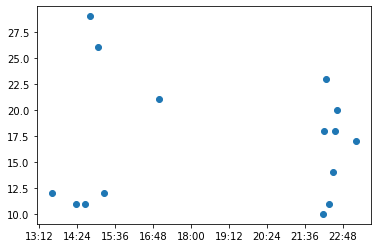

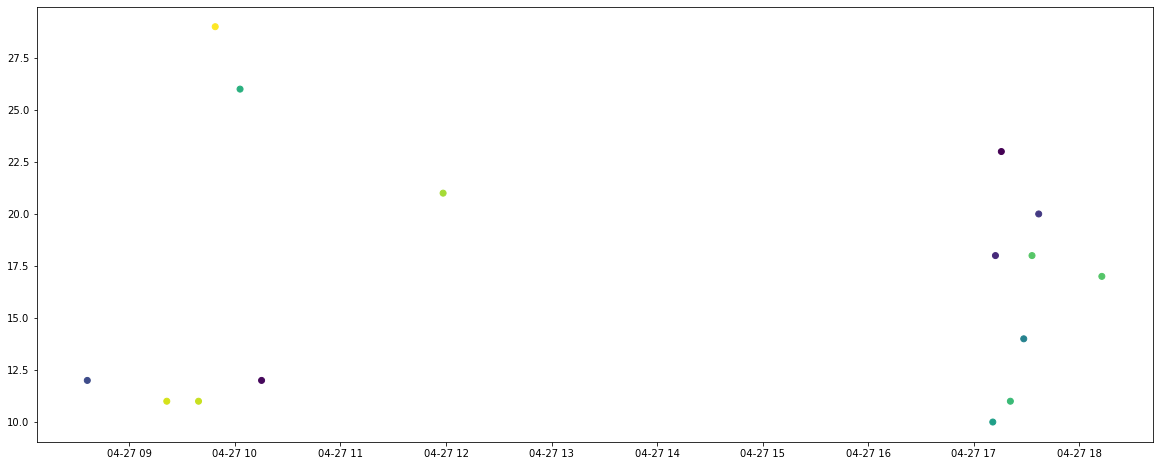

In [58]:
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
'''for i in range(0,15):
    time_message = str(getrealtime(i).strftime('This clip is from time %H:%M on date %d-%m-%Y.'))
    print(time_message)'''

xaxistimes = []
for i in range(0,15):
    xaxistimes.append((getrealtime(i) ))
x = matplotlib.dates.date2num(xaxistimes) 
ax = plt.axes()
yaxiscounts = sorted_ctccount['convo_count'][0:15]
colors = np.random.rand(15)
plt.figure(figsize=(20, 8)) 
plt.scatter (xaxistimes, yaxiscounts, c=colors)
#fmt = xaxistimes.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(fmt)
ax.scatter(x , yaxiscounts)
plt.show()

In [55]:
ax.xaxis.set_major_formatter(fmt)


In [48]:
#print (sorted_ctccount['convo_count'][0:15])
print((getrealtime(0).time()))

09:48:47


## Experiments with types of visualizations

In [3]:
childid = '032LTP2'
filepath_of_csv = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles" , childid+ "_speech_output", childid+"_MAN_timestamps.csv")
man_timestamps_main = pd.read_csv(filepath_of_csv)


In [5]:
man_timestamps_main['words_per_sec'] = man_timestamps_main['wordCount']/man_timestamps_main['duration']

In [17]:
man_timestamps_main['words_per_sec'] 

0       4.801325
1       5.854701
2       7.435644
3       5.126316
4       7.198020
          ...   
1512    2.084906
1513    4.850877
1514    3.857143
1515    3.504348
1516    4.038835
Name: words_per_sec, Length: 1517, dtype: float64

In [18]:
man_timestamps_main 

,Unnamed: 0,seg_id,clip_onset,clip_offset,duration,avg_dB,peak_dB,wordCount,nonSpeechDur,uttCnt,uttLength,file_name,seconds,child_id,segment_type,random_idx,words_per_sec
0,0,1,16.88,18.39,1.51,-34.80,-25.78,7.25,P0.00S,0,P0.00S,16_18_MAN_032LTP2.wav,60.0,032LTP2,MAN,927,4.801325
1,1,2,54.35,55.52,1.17,-40.89,-32.53,6.85,P0.00S,0,P0.00S,54_55_MAN_032LTP2.wav,60.0,032LTP2,MAN,1488,5.854701
2,2,3,170.29,171.30,1.01,-38.02,-30.02,7.51,P0.00S,0,P0.00S,170_171_MAN_032LTP2.wav,180.0,032LTP2,MAN,112,7.435644
3,3,4,192.76,194.66,1.90,-30.27,-22.73,9.74,P0.00S,0,P0.00S,192_194_MAN_032LTP2.wav,240.0,032LTP2,MAN,222,5.126316
4,4,5,198.09,199.10,1.01,-29.02,-20.63,7.27,P0.00S,0,P0.00S,198_199_MAN_032LTP2.wav,240.0,032LTP2,MAN,686,7.198020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,1512,1513,45309.36,45310.42,1.06,-34.16,-27.06,2.21,P0.00S,0,P0.00S,45309_45310_MAN_032LTP2.wav,45360.0,032LTP2,MAN,1175,2.084906
1513,1513,1514,45326.16,45327.30,1.14,-33.43,-28.35,5.53,P0.00S,0,P0.00S,45326_45327_MAN_032LTP2.wav,45360.0,032LTP2,MAN,433,4.850877
1514,1514,1515,46246.22,46247.48,1.26,-40.36,-32.40,4.86,P0.00S,0,P0.00S,46246_46247_MAN_032LTP2.wav,46260.0,032LTP2,MAN,1472,3.857143
1515,1515,1516,46790.98,46793.28,2.30,-36.41,-27.64,8.06,P0.00S,0,P0.00S,46790_46793_MAN_032LTP2.wav,46800.0,032LTP2,MAN,1292,3.504348


Alternate strategy: Aggregate the whole df into 20 bins (in chronological order) and then take talking speed

In [37]:
man_timestamps1 = man_timestamps_main
man_timestamps1['value_bin']=pd.cut(man_timestamps_main['clip_offset'], 20, labels=[x for x in range(1,21)])
man_timestamps1['freq_bin']=pd.qcut(man_timestamps_main['clip_offset'], 20, labels=[x for x in range(1,21)])  

In [44]:
vbin_df = man_timestamps1.groupby('value_bin').agg('sum')
fbin_df = man_timestamps1.groupby('freq_bin').agg('sum')
vbin_df['wps'] = vbin_df['wordCount']/vbin_df['duration']
fbin_df['wps'] = fbin_df['wordCount']/fbin_df['duration']

In [48]:
vbin_df

,Unnamed: 0,seg_id,clip_onset,clip_offset,duration,avg_dB,peak_dB,wordCount,uttCnt,seconds,random_idx,words_per_sec,wps
value_bin,,,,,,,,,,,,,
1,703,741,59176.71,59227.59,50.88,-1260.77,-939.51,244.61,0,60360.0,26617,186.547506,4.807586
2,893,912,61640.68,61664.93,24.25,-622.79,-458.21,100.88,0,62160.0,15790,79.216842,4.160000
3,13110,13225,737787.43,737976.59,189.16,-3851.75,-2789.62,776.58,0,741420.0,88610,499.182649,4.105413
4,29845,29972,1073965.92,1074153.93,188.01,-3518.53,-2474.39,780.92,0,1078020.0,93601,546.625125,4.153609
5,27080,27160,881309.09,881431.68,122.59,-2154.64,-1526.68,485.23,0,883740.0,62911,312.633651,3.958153
6,86010,86193,2359213.46,2359504.49,291.03,-5058.00,-3552.07,1187.64,0,2364900.0,139358,757.986551,4.080816
7,126994,127187,3052709.31,3053009.55,300.24,-5331.44,-3699.51,1196.90,0,3058800.0,142670,779.135098,3.986477
8,116325,116466,2478866.35,2479058.70,192.35,-4329.29,-3063.08,759.98,0,2483460.0,101191,567.046234,3.951027
9,6293,6300,137109.84,137118.83,8.99,-227.35,-158.76,36.24,0,137280.0,7380,28.578216,4.031146


In [51]:
man_vbin_offset_df = man_timestamps1.groupby('value_bin').agg({'duration': 'sum', 'wordCount': 'sum', 'clip_offset':'max'})
man_vbin_offset_df['hourly_offset'] = man_vbin_offset_df['clip_offset']/3600
man_vbin_offset_df['avg_speed_recorded'] = man_vbin_offset_df['wordCount']/man_vbin_offset_df['duration']

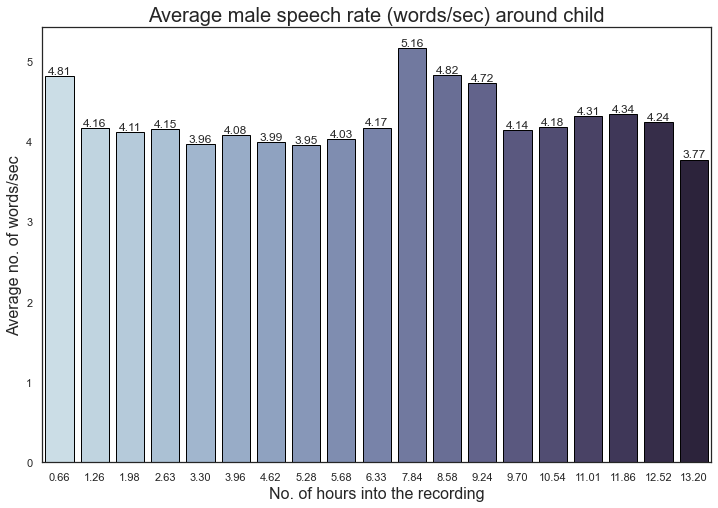

In [84]:
man_vbin_offset_df.dropna(inplace=True)
import seaborn as sns
import matplotlib.pyplot as plt
truncated_x = ['{:.2f}'.format(t) for t in man_vbin_offset_df['hourly_offset']]
truncated_y = [round(t,2) for t in man_vbin_offset_df['avg_speed_recorded']]
ax = sns.barplot(x = man_vbin_offset_df['hourly_offset'], y = truncated_y, palette = "ch:s=.25,rot=-.25",edgecolor='black')
ax.bar_label(ax.containers[0], fontsize=12)
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme(style='white')
plt.xticks(rotation=0)
ax.set_xticklabels(truncated_x)
plt.xlabel('No. of hours into the recording', fontsize=16)
plt.ylabel('Average no. of words/sec', fontsize=16)
plt.title("Average male speech rate (words/sec) around child", fontsize=20)
plt.show()

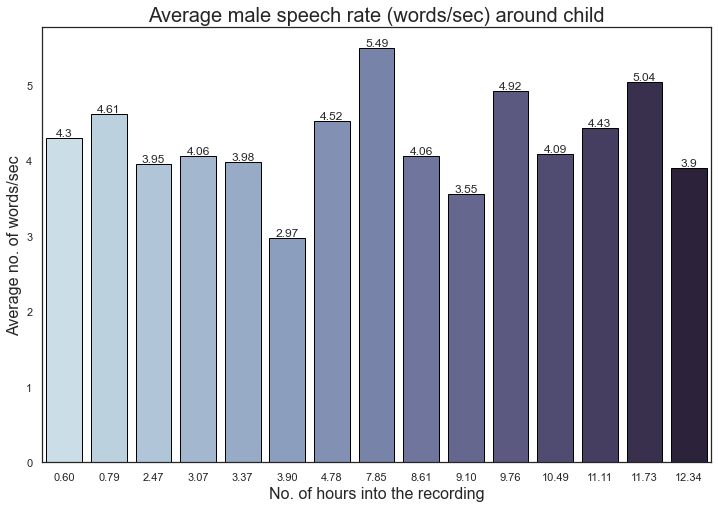

In [87]:
# Refactoring code into function -- change variables when integrating into script

import seaborn as sns
import matplotlib.pyplot as plt

def create_MAN_speed_graph(childid):
    filepath_of_csv = os.path.join("/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles" , childid+ "_speech_output", childid+"_MAN_timestamps.csv")
    man_timestamps_main = pd.read_csv(filepath_of_csv)
    man_timestamps1 = man_timestamps_main
    man_timestamps1['value_bin']=pd.cut(man_timestamps_main['clip_offset'], 20, labels=[x for x in range(1,21)])
    man_timestamps1['freq_bin']=pd.qcut(man_timestamps_main['clip_offset'], 20, labels=[x for x in range(1,21)])

    '''
    vbin_df = man_timestamps1.groupby('value_bin').agg('sum')
    fbin_df = man_timestamps1.groupby('freq_bin').agg('sum')
    vbin_df['wps'] = vbin_df['wordCount']/vbin_df['duration']
    fbin_df['wps'] = fbin_df['wordCount']/fbin_df['duration']
    '''

    man_vbin_offset_df = man_timestamps1.groupby('value_bin').agg({'duration': 'sum', 'wordCount': 'sum', 'clip_offset':'max'})
    man_vbin_offset_df['hourly_offset'] = man_vbin_offset_df['clip_offset']/3600
    man_vbin_offset_df['avg_speed_recorded'] = man_vbin_offset_df['wordCount']/man_vbin_offset_df['duration']

    man_vbin_offset_df.dropna(inplace=True)

    truncated_x = ['{:.2f}'.format(t) for t in man_vbin_offset_df['hourly_offset']]
    truncated_y = [round(t,2) for t in man_vbin_offset_df['avg_speed_recorded']]
    ax = sns.barplot(x = man_vbin_offset_df['hourly_offset'], y = truncated_y, palette = "ch:s=.25,rot=-.25",edgecolor='black')
    ax.bar_label(ax.containers[0], fontsize=12)
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_theme(style='white')
    plt.xticks(rotation=0)
    ax.set_xticklabels(truncated_x)
    plt.xlabel('No. of hours into the recording', fontsize=16)
    plt.ylabel('Average no. of words/sec', fontsize=16)
    plt.title("Average male speech rate (words/sec) around child", fontsize=20)
    plt.show()

create_MAN_speed_graph('001LTP1')

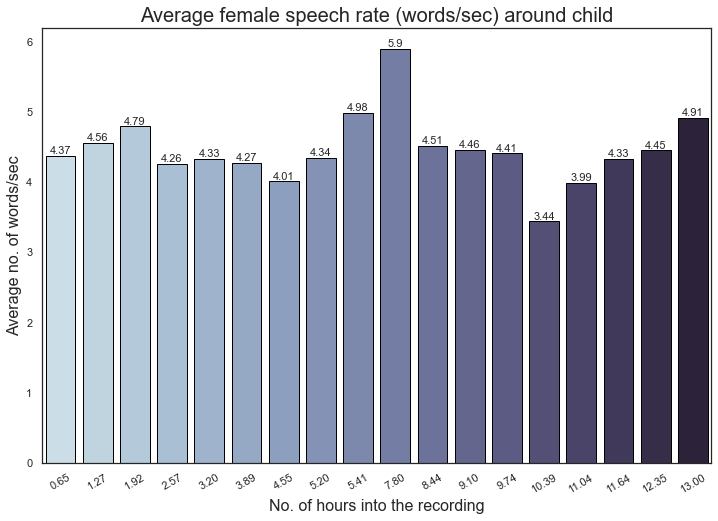

In [88]:
def create_FAN_speed_graph(id):

        '''
        This function creates a plot of male talking speed by mining MAN timestamps and saves it in the output directory. This has binning done w.r.t. values of offsets.
        '''

        filepath_of_csv = os.path.join( "/Users/arjun/Box/box-group-lena-studies/Soundscape/wavFiles",  id+ "_speech_output",  id+"_FAN_timestamps.csv")
        man_timestamps_main = pd.read_csv(filepath_of_csv)
        man_timestamps1 = man_timestamps_main
        man_timestamps1['value_bin']=pd.cut(man_timestamps_main['clip_offset'], 20, labels=[x for x in range(1,21)])
        man_timestamps1['freq_bin']=pd.qcut(man_timestamps_main['clip_offset'], 20, labels=[x for x in range(1,21)])
        man_vbin_offset_df = man_timestamps1.groupby('value_bin').agg({'duration': 'sum', 'wordCount': 'sum', 'clip_offset':'max'})
        man_vbin_offset_df['hourly_offset'] = man_vbin_offset_df['clip_offset']/3600
        man_vbin_offset_df['avg_speed_recorded'] = man_vbin_offset_df['wordCount']/man_vbin_offset_df['duration']

        man_vbin_offset_df.dropna(inplace=True)

        truncated_x = ['{:.2f}'.format(t) for t in man_vbin_offset_df['hourly_offset']]
        truncated_y = [round(t,2) for t in man_vbin_offset_df['avg_speed_recorded']]
        ax = sns.barplot(x = man_vbin_offset_df['hourly_offset'], y = truncated_y, palette = "ch:s=.25,rot=-.25",edgecolor='black')
        ax.bar_label(ax.containers[0], fontsize=11)
        sns.set(rc={'figure.figsize':(12,8)})
        sns.set_theme(style='white')
        plt.xticks(rotation=30)
        ax.set_xticklabels(truncated_x)
        plt.xlabel('No. of hours into the recording', fontsize=16)
        plt.ylabel('Average no. of words/sec', fontsize=16)
        plt.title("Average female speech rate (words/sec) around child", fontsize=20)
        plt.show()

create_FAN_speed_graph("001LTP1")